<a href="https://colab.research.google.com/github/mthsansu/MLNLP/blob/side/Code/BERT_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="chillipepper">**Settings**</font>

### <font color="chillipepper">**Imports and Installation**</font>

In [1]:
!pip install transformers
!pip install sentencepiece
!pip install keras
!pip install tensorflow
!pip3 install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 4.0 MB 7.9 MB/s 
     |████████████████████████████████| 6.6 MB 45.9 MB/s 
     |████████████████████████████████| 596 kB 17.5 MB/s 
     |████████████████████████████████| 77 kB 7.1 MB/s 
     |████████████████████████████████| 895 kB 52.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 7.9 MB/s 
     |████████████████████████████████| 462 kB 7.4 MB/s 
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 12.0 MB/s eta 0:01:36tcmalloc: large alloc 1147494400 bytes == 0x555e2711c000 @  0x7fbfdec26615 0x555decbd117c 0x555deccb147a 0x555decbd3f9d 0x555deccc5d4d 0x555decc47ec8 0x555decc42a2e 0x555decbd588a 0x555decc47d30 0x555decc42a2e 0x555decbd588a 0x555decc44719 0x555deccc6b76 0x555decc43d95 0x555deccc6b76 0x555decc43d95 0x555deccc6

In [2]:
import os
import time
import datetime
import random
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
from scipy.special import softmax
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,precision_recall_fscore_support, confusion_matrix
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from transformers import CamembertTokenizer, CamembertConfig,\
                         AdamW, get_linear_schedule_with_warmup,\
                         WEIGHTS_NAME, CONFIG_NAME
from transformers import CamembertForSequenceClassification
from termcolor import colored
import re
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn

### <font color="chillipepper">**GPU Settings**</font>

In [3]:
if torch.cuda.is_available(): # torch.cuda.is_available() returns a boolean to check if the GPU can be used or not
  device = 'cuda' # if CUDA is available set 'cuda' as the device
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) ) # print the name of the GPU
else:
  device = 'cpu' # set 'cpu' as device if CUDA not available
  print('DEVICE = ', colored('CPU', "blue")) # print that the CPU is used
device = torch.device(device) # Set the available device

DEVICE =  Tesla T4


# <font color="chillipepper">**Model building**</font>

### <font color="chillipepper">**Preprocessing function**</font>

In [4]:
def clean(text): # Parameter will be a text, here a tweet
    text = re.sub("@","", text) # Removing the "@" from mention
    text = re.sub(r'http\S+', '', text) # Removing url links
    text = text.replace('\n',' ') # Removing new line
    text = text.replace('\r',' ') # Removing new line
    text = re.sub('#', '', text) # Removing hash
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) # remove emoji
    a = re.compile('<U(.*?)>') # other missing emoji_pattern
    text = a.sub(r'', text) # remove these remaining emoji
    text = re.sub(' +', ' ', text) # Remove additional spaces
    return text # The output is the cleaned text

### <font color="chillipepper">**Tokenizer**</font>

In [5]:
# Tokenizer conceived for CamemBERT classification. We use camembert-base
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

### <font color="chillipepper">**Modeling functions**</font>

In [6]:
# Encoding function
        # `encode` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.  
def encode(sentences, labels=None, tokenizer=tokenizer, batch_size=32, progress_bar=True):
    input_ids = []
    if progress_bar:
        sent_loader = tqdm(sentences)
    else:
        sent_loader = sentences
    for sent in sent_loader:
        encoded_sent = tokenizer.encode(sent,                       # Sentence to encode
                                        add_special_tokens = True,   # Add '[CLS]' token to the start and '[SEP]' token to the end
                                        max_length = 512)          # Truncate all sentences
        input_ids.append(encoded_sent)
        
    MAX_LEN = min(max([len(sen) for sen in input_ids]), 512)

    # Pad our input tokens with value 0.
    # "post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning.
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")

    # Create attention masks
    attention_masks = []
    if progress_bar:
        input_loader = tqdm(input_ids)
    else:
        input_loader = input_ids
    for sent in input_loader:
        # Create the attention mask.
        #   - If a token ID is 0, then it's padding, set the mask to 0.
        #   - If a token ID is > 0, then it's a real token, set the mask to 1.
        att_mask = [int(token_id > 0) for token_id in sent]

        attention_masks.append(att_mask)
    
    if labels is None:
        # Convert to pytorch tensors
        inputs_tensors = torch.tensor(input_ids)
        masks_tensors = torch.tensor(attention_masks)

        # Create the DataLoader 
        data = TensorDataset(inputs_tensors, masks_tensors)
        sampler = SequentialSampler(data)
        dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
        return dataloader        
    else:
        # Convert to pytorch tensors
        inputs_tensors = torch.tensor(input_ids)
        masks_tensors = torch.tensor(attention_masks)
        labels_tensors = torch.tensor(labels)

        # Create the DataLoader 
        data = TensorDataset(inputs_tensors, masks_tensors, labels_tensors)
        sampler = SequentialSampler(data)
        dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
        return dataloader

In [7]:
# Function to return time elapsed
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded)) # Format as hh:mm:ss

In [8]:
# Model training
def run_training(train_dataloader, # train data
                 test_dataloader, # test data
                 n_epochs=3, # number of epochs
                 lr=0.001, # learning rate
                 seed_val=2018, 
                 save_model_as=None): # saving the model to implement it on other data later
    
    # Unpack all test labels for evaluation
    test_labels = []
    for batch in test_dataloader:
        test_labels += batch[2].numpy().tolist()
    num_labels = np.unique(test_labels).size
    
    # Set the seed value all over the place to make this reproducible.
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    
    # Load model
    model = CamembertForSequenceClassification.from_pretrained("camembert-base", 
                                                               num_labels = num_labels, 
                                                               output_attentions = False, 
                                                               output_hidden_states = False)
    # Tell pytorch to run this model on the GPU.
    model.cuda()
    
    optimizer = AdamW(model.parameters(), lr = lr, eps = 1e-8)
    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=len(train_dataloader) * n_epochs)
    #total number of training steps is number of batches * number of epochs.

    # Store the average loss after each epoch so we can plot them.
    train_loss_values = []
    test_loss_values = []

    # TRAINING
    
    for i_epoch in range(n_epochs): # each epoch
        # Perform one full pass over the training set.   
        print("")
        print('======== Epoch {:} / {:} ========'.format(i_epoch + 1, n_epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total train loss for this epoch.
        total_train_loss = 0
        total_test_loss = 0  # Reset the total train loss for this epoch.

        # Put the model in training mode
        model.train()

        for step, train_batch in enumerate(train_dataloader): # each batch
            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_inputs = train_batch[0].to(device)
            b_masks = train_batch[1].to(device)
            b_labels = train_batch[2].to(device)

            # Clear any previously calculated gradients before performing a
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # This will return the loss (rather than the model output) because we have provided the `labels`.
            outputs = model(b_inputs, token_type_ids=None, attention_mask=b_masks,labels=b_labels)

            # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple.
            loss = outputs[0]

            # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end.
            # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1. This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()
            
        # Calculate the average loss over the training data batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            

        # Store the loss value for plotting the learning curve.
        train_loss_values.append(avg_train_loss)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

        # VALIDATION
        # After the completion of each training epoch, measure our performance on our validation set.
        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
        model.eval()

        logits_complete = [] # store logits of each batch

        # Evaluate data for one epoch
        for test_batch in test_dataloader:
            # Add batch to GPU
            b_inputs = test_batch[0].to(device)
            b_masks = test_batch[1].to(device)
            b_labels = test_batch[2].to(device)

            # Telling the model not to compute or store gradients, saving memory and speeding up validation
            with torch.no_grad():        
                # Forward pass, calculate test loss and logit predictions.
                # token_type_ids = None : it's not 2-sentences task
                outputs = model(b_inputs, token_type_ids=None, attention_mask=b_masks,labels=b_labels)

            loss = outputs[0].item() # get loss
            logits = outputs[1]      # get logits
            
            # Move logits CPU
            logits = logits.detach().cpu().numpy()
            #labels_id = b_labels.to('cpu').numpy()
            
            total_test_loss += loss
            logits_complete.append(logits)
            
        logits_complete = np.concatenate(logits_complete)
        
        # Calculate the average loss over the test data batches.
        avg_test_loss = total_test_loss / len(test_dataloader)            
        # Store the loss value for plotting the learning curve.
        test_loss_values.append(avg_test_loss)
        
        print("")
        print("  Average test loss: {0:.2f}".format(avg_test_loss))
        print("  Validation took: {:}".format(format_time(time.time() - t0)))
        print(classification_report(test_labels, np.argmax(logits_complete, axis=1).flatten()))
        score = precision_recall_fscore_support(test_labels, np.argmax(logits_complete, axis=1).flatten())

    # End of all epochs
    print("")
    print("Training complete!")
    
    if save_model_as is not None:
        # SAVE
        output_dir = "./models/{}".format(save_model_as)
        try:
            os.makedirs(output_dir)
        except:
            pass
        
        # Step 1: Save a model, configuration and vocabulary that you have fine-tuned
        # If we have a distributed model, save only the encapsulated model
        # (it was wrapped in PyTorch DistributedDataParallel or DataParallel)
        model_to_save = model.module if hasattr(model, 'module') else model

        # If we save using the predefined names, we can load using `from_pretrained`
        output_model_file = os.path.join(output_dir, WEIGHTS_NAME)
        output_config_file = os.path.join(output_dir, CONFIG_NAME)

        torch.save(model_to_save.state_dict(), output_model_file)
        model_to_save.config.to_json_file(output_config_file)
        tokenizer.save_vocabulary(output_dir)

    return score

In [9]:
# Predict function
def predict(dataloader, model, proba=True, progress_bar=True):
    logits_complete = []
    # Evaluate data for one epoch
    if progress_bar:
        loader = tqdm(dataloader)
    else:
        loader = dataloader
    for batch in loader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        if len(batch)==3:
            b_input_ids, b_input_mask, _ = batch
        else:
            b_input_ids, b_input_mask = batch

        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            token_type_ids=None,  # not a 2-sentence task
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        logits_complete.append(logits)
        
        del outputs        
        torch.cuda.empty_cache() #release GPU memory
        
        pred = np.concatenate(logits_complete) #flatten batches
    if proba:
        return softmax(pred, axis=1)
    else:
        return pred

In [10]:
# Apply the trained model on a corpus
def predict_with_model(dataloader, model_path, proba=True):
    model = CamembertForSequenceClassification.from_pretrained(model_path)
    model.cuda()
    return predict(dataloader, model, proba)

# <font color="chillipepper">**Model training**</font>

### <font color="chillipepper">**Annotated data**</font>

In [11]:
# The data are provided in the github repository
git_url = "https://raw.githubusercontent.com/mthsansu/MLNLP/main/Data/"
df = pd.read_csv(git_url + 'df_baseline.csv', index_col =0, engine='python')

In [12]:
df["text"] = df["text"].apply(lambda x: clean(x))
# df = df.rename(columns={"label_sansu":"value"})
df = df.rename(columns={"Label":"value"})
df = df[["text","value"]]

In [13]:
# Show the distribution of labels in human-annotated sample
df.value.value_counts()

0    377
1    368
2    255
Name: value, dtype: int64

### <font color="chillipepper">**Train and test sets**</font>

In [14]:
# Randomly split the data into 2 samples 'train' and 'test' for the execution of ML tasks
train, test = train_test_split(df, test_size=0.2)

In [15]:
test.head()

,text,value
125,Quand vous vivez avec moins de 1000€ par mois...,1
852,Je serai l’invitée de BFMTV ce samedi à 11h30...,0
761,Réunion avec l’ars_normandie avec mes collègue...,1
544,QEG L'association L214 a révélé dernièrement d...,2
769,« Le projet M. Macron est un projet de déracin...,2


In [16]:
# Encode the 'train' and 'test' samples using the `encode()` function defined above
train_dataloader = encode(train.text.values, train.value.values, batch_size=32)
test_dataloader = encode(test.text.values, test.value.values, batch_size=256)

  0%|          | 0/800 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

### <font color="chillipepper">**Perform train step**</font>

In [38]:
score = run_training(train_dataloader, 
                                  test_dataloader, 
                                  n_epochs=3, 
                                  lr=0.001, 
                                  seed_val=2018, 
                                  save_model_as="sentiment_tweet")

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 


======== Epoch 1 / 3 ========
Training...

  Average training loss: 1.13
  Training epcoh took: 0:00:13

Running Validation...

  Average test loss: 1.07
  Validation took: 0:00:01
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.36      1.00      0.53        73
           2       0.00      0.00      0.00        40

    accuracy                           0.36       200
   macro avg       0.12      0.33      0.18       200
weighted avg       0.13      0.36      0.20       200


======== Epoch 2 / 3 ========
Training...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat


  Average training loss: 1.09
  Training epcoh took: 0:00:13

Running Validation...

  Average test loss: 1.09
  Validation took: 0:00:01
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.36      1.00      0.53        73
           2       0.00      0.00      0.00        40

    accuracy                           0.36       200
   macro avg       0.12      0.33      0.18       200
weighted avg       0.13      0.36      0.20       200


======== Epoch 3 / 3 ========
Training...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat


  Average training loss: 1.10
  Training epcoh took: 0:00:13

Running Validation...

  Average test loss: 1.06
  Validation took: 0:00:01
              precision    recall  f1-score   support

           0       0.43      1.00      0.61        87
           1       0.00      0.00      0.00        73
           2       0.00      0.00      0.00        40

    accuracy                           0.43       200
   macro avg       0.14      0.33      0.20       200
weighted avg       0.19      0.43      0.26       200


Training complete!


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

# <font color="chillipepper">**Model evaluating**</font>

In [18]:
# Encode the 'values' column in the test set to prepare it for prediction
predict_loader = encode(test.text.values)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [19]:
# Apply our model on the dataloader encoded in the previous cell
pred = predict_with_model(predict_loader, model_path='./models/sentiment_tweet/', proba=True)

  0%|          | 0/7 [00:00<?, ?it/s]

In [20]:
# We get the label prediction and probability of prediction
test['pred'] = np.argmax(pred, axis=1)
test['prob_1'] = pred[:,1]

In [21]:
test.pred.value_counts()

0    90
2    56
1    54
Name: pred, dtype: int64

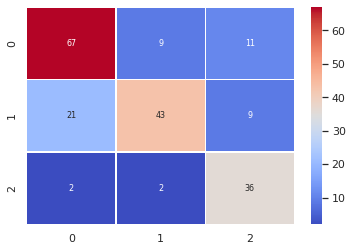

In [22]:
# Confusion matrix
names = [0,1,2]
cm = confusion_matrix(np.array(test.value.tolist()).flatten(), np.array(test.pred.tolist()).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

In [23]:
# Cross Validation Classification Report
report = classification_report(np.array(test.value.tolist()).flatten(), np.array(test.pred.tolist()).flatten())
print(report)

              precision    recall  f1-score   support

           0       0.74      0.77      0.76        87
           1       0.80      0.59      0.68        73
           2       0.64      0.90      0.75        40

    accuracy                           0.73       200
   macro avg       0.73      0.75      0.73       200
weighted avg       0.74      0.73      0.73       200



### <font color="chillipepper">**Evaluate time complexity**</font>

In [31]:
!pip install big_O

  Created wheel for big-O: filename=big_O-0.10.2-py3-none-any.whl size=10035 sha256=e83f7e39bb3843f25ee7febd555c0c05318195934753dcd35e0451a777354fc0
  Stored in directory: /root/.cache/pip/wheels/b6/29/d2/fb6530b47b5e4f1b5b4655e3dd53b1d609a1978cf7d6880077
Successfully built big-O


In [33]:
import big_o

In [36]:
positive_int_generator = lambda n: big_o.datagen.integers(n, 0, 10000)
best, others = big_o.big_o(, positive_int_generator, n_repeats=100)
print(best)

TypeError: ignored

### <font color="chillipepper">**Evaluate space complexity**</font>

# <font color="chillipepper">**Applying the model**</font>

### <font color="chillipepper">**Data to classify**</font>

In [24]:
# List of samples we want to work on
list_data = ['Tweets_sample_confinement', 'Tweets_sample_benalla', 'Tweets_sample_CDM']

### <font color="chillipepper">**Classification loop**</font>

In [25]:
for i in range(2,len(list_data)):
  df_study = pd.read_csv(git_url + list_data[i] + '.csv', index_col =0, engine='python')
  df_study["text"] = df_study["text"].apply(lambda x: clean(x))
  df_study_loader = encode(df_study.text.values)
  pred_df_study = predict_with_model(df_study_loader, model_path='./models/sentiment_tweet/', proba=True)
  df_study['pred'] = np.argmax(pred_df_study, axis=1)
  df_study['prob_1'] = pred_df_study[:,1]
  df_study.to_csv(ist_data[i] + '_pred.csv')

  0%|          | 0/31204 [00:00<?, ?it/s]

  0%|          | 0/31204 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

NameError: ignored

# <font color="chillipepper">**Interpretations**</font>

In [ ]:
df_study = pd.read_csv(list_data[0] + '_pred.csv', index_col =0, engine='python')
df_study['date'] = pd.to_datetime(df_study['created_at']).dt.date
df_study.head()